
Attention-based Association Model
---



# Загрузка моделей и датасета



In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/text2image'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import time

from pathlib import Path

import gensim
import gensim.downloader as api
import numpy as np
import pandas as pd
import tqdm

from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from pymystem3 import Mystem
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision import models

%matplotlib inline

In [3]:
%%time
os.makedirs('models', exist_ok=True)

w2v_path = Path('models/food_w2v_300.w2v')
resnet_path = Path('models/Resnet50_feature_extractor.pth')

if not os.path.exists('GDriveDL.py'):
    !wget https://raw.githubusercontent.com/matthuisman/gdrivedl/master/gdrivedl.py -O GDriveDL.py


if not os.path.exists(resnet_path): 
    !python GDriveDL.py https://drive.google.com/file/d/105esXE4a6uQVbzhaljPy1LnUf6v-CoDO/view?usp=sharing models

if not os.path.exists(w2v_path): 
    !python GDriveDL.py https://drive.google.com/file/d/12HZPgb7803nJcCwsiV-Q2XRaofRguUbt/view?usp=sharing models

os.makedirs('data', exist_ok=True)
if not os.path.exists('data/eda_ru.zip'): 
    !python GDriveDL.py https://drive.google.com/file/d/1CNIbj8_OuxQD74zt6JU4BUI8ngctutl9/view?usp=sharing data
    !unzip -q data/eda_ru.zip -d data

CPU times: user 175 µs, sys: 0 ns, total: 175 µs
Wall time: 180 µs


In [4]:
df = pd.read_csv('data/eda_ru_filtered.csv')
df.head()

,id,url,title,ingredients,descr,steps,images,images_step
0,24419,https://eda.ru/recepty/vypechka-deserty/sloeni...,Слоеные булки,Вода:350 мл|Пшеничная мука:500 г|Соль:по вкусу...,NaN,1. Вотрите дрожжи в муку до образования одноро...,images/24419_1.jpg,NaN
1,24410,https://eda.ru/recepty/vypechka-deserty/italja...,Итальянское персиковое мороженое (Gelato),Молоко:6 стаканов|Сахар:1 стакан|Яичный желток...,NaN,1. В блендере измельчите очищенные от кожуры п...,images/24410_1.jpg,NaN
2,24411,https://eda.ru/recepty/vypechka-deserty/italja...,Итальянское мороженое с лимонной цедрой (Gelato),Молоко:6 стаканов|Сахар:1 стакан|Яичный желток...,NaN,1. В большой кастрюле смешайте слегка взбитые ...,images/24411_1.jpg,NaN
3,24414,https://eda.ru/recepty/salaty/zakuska-iz-kuric...,Закуска из курицы в листьях салата,Куриная грудка:1 штука|Оливковое масло:3 столо...,NaN,"1. Смешайте ингредиенты для соуса: масло, соев...",images/24414_1.jpg,NaN
4,24413,https://eda.ru/recepty/zakuski/marinovannie-ku...,Маринованные куриные ломтики,Лайм:1 штука|Чеснок:1 зубчик|Соевый соус:2 сто...,NaN,"1. Приготовьте маринад из сока и цедры лайма, ...",images/24413_1.jpg,NaN


In [4]:
m = Mystem()
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


--2020-11-18 18:33:50--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.241, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm902.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2020-11-18 18:33:51--  http://cache-mskm902.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm902.cdn.yandex.net (cache-mskm902.cdn.yandex.net)... 5.45.220.12, 2a02:6b8:0:2002::13
Connecting to cache-mskm902.cdn.yandex.net (cache-mskm902.cdn.yandex.net)|5.45.220.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  1

# Utility functions

In [5]:
m = Mystem()

tag_conversion = {
    'A': 'ADJ',                                                                                                                                                                                                                                                                    
    'ADV': 'ADV',                                                                                                                                                                                                                                                                    
    'ADVPRO': 'ADV',                                                                                                                                                                                                                                                                    
    'ANUM': 'ADJ',                                                                                                                                                                                                                                                                    
    'APRO': 'DET',                                                                                                                                                                                                                                                                    
    'COM': 'ADJ',                                                                                                                                                                                                                                                                    
    'CONJ': 'SCONJ',                                                                                                                                                                                                                                                                  
    'INTJ': 'INTJ',                                                                                                                                                                                                                                                                   
    'NONLEX': 'X',                                                                                                                                                                                                                                                                      
    'NUM': 'NUM',                                                                                                                                                                                                                                                                    
    'PART': 'PART',                                                                                                                                                                                                                                                                   
    'PR': 'ADP',                                                                                                                                                                                                                                                                    
    'S': 'NOUN',                                                                                                                                                                                                                                                                   
    'SPRO': 'PRON',                                                                                                                                                                                                                                                                   
    'UNKN': 'X',                                                                                                                                                                                                                                                                      
    'V':'VERB'
}

def tag(word='пожар', m=m):
    
    processed = m.analyze(word)[0]
    if not "analysis" in processed:
        raise ValueError('Wrong word')
    if not processed["analysis"]:
        raise ValueError('Wrong word')
    lemma = processed["analysis"][0]["lex"].lower().strip()
    pos = processed["analysis"][0]["gr"].split(',')[0]
    pos = pos.split('=')[0].strip()
    tagged = lemma+'_'+tag_conversion[pos]
    return tagged

# Построим и сохраним W2V эмбеддинги для Названий и ингредиентов

In [6]:
os.makedirs('data/embeddings/w2v', exist_ok=True)
emdeddings_path = Path('data/embeddings/w2v')

## Соберем словарь word2tag


In [8]:
titles = list(df.title.values)
steps = []
for recipe in df.steps.values:
    steps.extend(recipe.split('|'))
sentences = titles + steps
print(len(sentences))
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenized = [w.lower() for w in sentences]
sentences_tokenized = [tokenizer.tokenize(i) for i in sentences_tokenized]

186952


In [9]:
word_to_tag = {}
wrong_words = set()
for s in tqdm.tqdm(sentences_tokenized):
    for w in s:
        if (w not in wrong_words) and (w not in word_to_tag):
            try:
                w_tag = tag(w)
            except ValueError:
                wrong_words.add(w)
                continue
            word_to_tag[w] = w_tag

100%|██████████| 186952/186952 [00:07<00:00, 23430.09it/s]


## Сконвертируем все теги 

In [10]:
model = Word2Vec.load(str(w2v_path))

In [11]:
titles = list(df.title.values)
titles = list(map(str.lower, titles))
ingredients = []
for recipe in df.ingredients.values:
    ingredients.append(recipe.split('|'))

In [12]:
print(titles[:5])
print(ingredients[:5])

['слоеные булки', 'итальянское персиковое мороженое (gelato)', 'итальянское мороженое с лимонной цедрой (gelato)', 'закуска из курицы в листьях салата', 'маринованные куриные ломтики']
[['Вода:350 мл', 'Пшеничная мука:500 г', 'Соль:по вкусу', 'Свежие дрожжи:10 г'], ['Молоко:6 стаканов', 'Сахар:1 стакан', 'Яичный желток:12 штук', 'Персики:8 штук'], ['Молоко:6 стаканов', 'Сахар:1 стакан', 'Яичный желток:12 штук', 'Лимонная цедра:1 столовая ложка'], ['Куриная грудка:1 штука', 'Оливковое масло:3 столовые ложки', 'Сок лайма:3 столовые ложки', 'Соевый соус:3 столовые ложки', 'Коричневый сахар:2 чайные ложки', 'Репчатый лук:1 головка', 'Белый винный уксус:2 столовые ложки', 'Салат айсберг:1 штука', 'Манго:1 штука', 'Редис:8 штук', 'Арахис:60 г', 'Мята:1 пучок'], ['Лайм:1 штука', 'Чеснок:1 зубчик', 'Соевый соус:2 столовые ложки', 'Мед:1 столовая ложка', 'Молотый перец чили:щепотка', 'Зеленый лук:1 пучок', 'Куриная грудка:1 штука', 'Растительное масло:2 столовые ложки']]


In [13]:
ingredients = [' '.join([t.lower().split(':')[0] for t in text]) for text in ingredients]
ingredients[:5]

['вода пшеничная мука соль свежие дрожжи',
 'молоко сахар яичный желток персики',
 'молоко сахар яичный желток лимонная цедра',
 'куриная грудка оливковое масло сок лайма соевый соус коричневый сахар репчатый лук белый винный уксус салат айсберг манго редис арахис мята',
 'лайм чеснок соевый соус мед молотый перец чили зеленый лук куриная грудка растительное масло']

In [14]:
sentences = [' '.join([u, v]) for (u, v) in zip(titles, ingredients)]
sentences[:5]

['слоеные булки вода пшеничная мука соль свежие дрожжи',
 'итальянское персиковое мороженое (gelato) молоко сахар яичный желток персики',
 'итальянское мороженое с лимонной цедрой (gelato) молоко сахар яичный желток лимонная цедра',
 'закуска из курицы в листьях салата куриная грудка оливковое масло сок лайма соевый соус коричневый сахар репчатый лук белый винный уксус салат айсберг манго редис арахис мята',
 'маринованные куриные ломтики лайм чеснок соевый соус мед молотый перец чили зеленый лук куриная грудка растительное масло']

In [15]:
df['sentence'] = sentences
df[['id', 'sentence']].head()

,id,sentence
0,24419,слоеные булки вода пшеничная мука соль свежие ...
1,24410,итальянское персиковое мороженое (gelato) моло...
2,24411,итальянское мороженое с лимонной цедрой (gelat...
3,24414,закуска из курицы в листьях салата куриная гру...
4,24413,маринованные куриные ломтики лайм чеснок соевы...


In [16]:
def make_w2v_embeddings(text, model=model, word2tag=word_to_tag):
    embds = []
    for word in text.split(' '):
        try:
            tag = word2tag[word]
        except KeyError:
            continue
        embds.append(model[tag])
    return np.array(embds)

In [17]:
%%time
lenghts = []
for idx, text in tqdm.tqdm(df[['id', 'sentence']].values):
    embds = make_w2v_embeddings(text)
    # print(embds.shape[0])
    lenghts.append(embds.shape[0])
    # print(lenghts)
    with open(emdeddings_path / f'{idx}.npz', 'wb') as f:
        np.savez(f, embds)
lenghts = np.array(lenghts)

  0%|          | 0/30091 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
100%|██████████| 30091/30091 [00:17<00:00, 1757.72it/s]

CPU times: user 14.4 s, sys: 2.41 s, total: 16.8 s
Wall time: 17.1 s


(array([3.000e+00, 1.600e+01, 0.000e+00, 4.700e+01, 1.260e+02, 0.000e+00,
        2.000e+02, 3.360e+02, 0.000e+00, 4.430e+02, 6.320e+02, 0.000e+00,
        8.650e+02, 1.006e+03, 0.000e+00, 1.326e+03, 1.480e+03, 0.000e+00,
        1.676e+03, 1.862e+03, 0.000e+00, 1.835e+03, 1.900e+03, 0.000e+00,
        1.845e+03, 1.772e+03, 0.000e+00, 1.683e+03, 1.531e+03, 0.000e+00,
        1.327e+03, 1.184e+03, 0.000e+00, 1.090e+03, 9.600e+02, 0.000e+00,
        7.970e+02, 7.390e+02, 0.000e+00, 5.990e+02, 5.170e+02, 0.000e+00,
        4.120e+02, 3.610e+02, 0.000e+00, 3.080e+02, 2.310e+02, 0.000e+00,
        2.030e+02, 0.000e+00, 1.480e+02, 1.150e+02, 0.000e+00, 1.040e+02,
        8.400e+01, 0.000e+00, 7.200e+01, 5.100e+01, 0.000e+00, 3.300e+01,
        3.700e+01, 0.000e+00, 2.700e+01, 1.900e+01, 0.000e+00, 1.700e+01,
        1.900e+01, 0.000e+00, 8.000e+00, 1.100e+01, 0.000e+00, 5.000e+00,
        6.000e+00, 0.000e+00, 7.000e+00, 5.000e+00, 0.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 1.000e+0

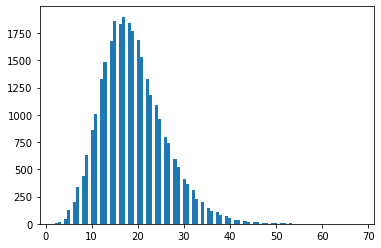

In [18]:
plt.hist(lenghts, bins=100)

# Датасет

Класс RecipeDataset - в качестве item возвращает картинку и эмбеддинги слов (n, 300). Индексы в этом датасете такие, что он отсортирован по количеству токенов в эмбеддинге, для более простого обучения модели.

In [5]:
class RecipeDataset(data.Dataset):
    def __init__(self, 
                 data=None,
                 data_dir='data', 
                 csv_filename='eda_ru_filtered.csv',
                 use_last_image=False,
                 base_size=64,
                 split = 'train',
                 split_ratio = 0.9,
                 transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        
        self.data_dir = Path(data_dir)
        self.csv_filename = csv_filename
        self.use_last_image = use_last_image
        if data is not None:
            self.data = data
        else:
            self.data = pd.read_csv(self.data_dir / self.csv_filename, usecols=['id', 'images'])
        if split == 'train':
            self.data = self.data.iloc[:int(len(self.data) * split_ratio)]
        elif split == 'val':
            self.data = self.data.iloc[int(len(self.data) * split_ratio):]
        else:
            raise Exception('Wrong split parameter - should be "train" or "val"')
        self.ids = self.data['id'].values
        self.images = self.data['images'].values
        
        self.embeddings, self.number_of_tokens = self.load_embeddings()
        self.num_tokens_order = np.argsort(self.number_of_tokens)

    
    def load_embeddings(self):

        embeddings = []
        number_of_tokens = []

        for idx in self.ids:
            emb = np.load(f'{self.data_dir}/embeddings/w2v/{idx}.npz')['arr_0']
            # ingredients_emb = np.load(f'{self.data_dir}/embeddings/ingredients/{idx}.npz')['arr_0']
            # steps_emb = np.load(f'{self.data_dir}/embeddings/steps/{idx}.npz')['arr_0']

            embeddings.append(emb)
            number_of_tokens.append(emb.shape[0])

        return np.array(embeddings), np.array(number_of_tokens)


    def __getitem__(self, idx):
        #
        idx = self.num_tokens_order[idx]
        image_pathes = self.images[idx].split('|')
        if self.use_last_image:
            img_path = image_pathes[-1]
        else:
            img_path = random.choice(image_pathes)
       
        # Загружаем изображение
        img = Image.open(self.data_dir / img_path).convert('RGB')
        width, height = img.size
        if self.transform is not None:
            img = self.transform(img)
        imgs = []
        imgs.append(img)
        
        # ИСПРАВИТЬ - временно для того чтобы проверить работоспособность в целом
        emb = self.embeddings[idx]
        
        return imgs, emb
    
    def __len__(self):
        return len(self.ids)

In [6]:
def collate_fn(input):
    # Соберем тензор картинок batch_size x 3 x size x size
    images, embeddings = zip(*input)
    images = torch.stack([image[0] for image in images])
    # Соберем тензор текстовых эмбеддингов
    max_len = np.max([text.shape[0] for text in embeddings])
    embeddings = list(embeddings)
    for i in range(len(embeddings)):
        if embeddings[i].shape[0] < max_len:
            num_spaces = max_len - embeddings[i].shape[0]
            pad_token = np.mean(embeddings[i], axis=0)
            tokens_to_add = np.tile(pad_token, (num_spaces, 1))
            embeddings[i] = np.concatenate([embeddings[i], tokens_to_add], axis=0)
    embeddings = torch.Tensor(embeddings)
    return images, embeddings

# Bidirectional LSTM + Attention

---



In [7]:
class SelfAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, encoder_outputs):
        # encoder_outputs = [t * batch_size * hid_dim]
        # Let's permute to [batch_size * t * hid_dim]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
    
        e = self.attn(encoder_outputs) # [batch_size * t * 1]

        # Calculate alpha = softmax(e)
        alpha = F.softmax(e, dim=1)

        attention = (alpha * encoder_outputs).sum(1).unsqueeze(-1)
        return attention.permute(2, 0, 1)

class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout, food_space_dim=1024):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=True
        )

        self.attn = SelfAttention(self.hid_dim * 2)
        self.fc = nn.Linear(hid_dim * 2, food_space_dim)
        
    def forward(self, src):
        
        #src = [batch size, sent len, embd]
        src = src.permute(1, 0, 2)
        
        output, (hidden, cell) = self.rnn(src)
        #output = [sent len, batch, 2*hidden_dim]
        
        output = self.attn(output)
        output = self.fc(output)

        return output.squeeze(0)

In [8]:
w2v_emb_dim = 300
hidden_dimm = 300
num_layers = 1
dropout = 0
lstmEncoder = Encoder(w2v_emb_dim, hidden_dimm, num_layers, dropout)

In [9]:
x = torch.normal(0, 1, (8, 4, 300))
output = lstmEncoder(x)
print(f'output: {output.shape}')

output: torch.Size([8, 1024])


# Resnet50 feature extractor



In [10]:
def load_resnet(food_space_dim=1024):
    resnet_fe = models.resnet50(pretrained=False)
    num_ftrs = resnet_fe.fc.in_features
    resnet_fe.fc = nn.Linear(num_ftrs, 101) # Чтобы загрузить веса обученной ранее модели модели
    resnet_fe.load_state_dict(torch.load(resnet_path))
    resnet_fe.fc = nn.Linear(num_ftrs, food_space_dim)
    return resnet_fe

# Соберем все вместе

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [12]:
path_to_save_models = Path(drive_path) / 'models'

def train(resnet_fe, lstm, optim, num_epochs, train_dataloader, val_dataloader, device):
    resnet_fe.to(device)
    lstm.to(device)
    train_losses = []
    train_plus = []
    train_minus = []
    val_losses = []
    val_plus = []
    val_minus = []
    min_loss = 3 # сумма 2 косинусов будет всегда меньше
    best_epoch = 0
    for i in range(num_epochs):
        print(f'Starting epoch #{i + 1}')
        train_losses.append([])
        train_plus.append([])
        train_minus.append([])
        time.sleep(1)
        resnet.train()
        lstm.train()
        for batch in tqdm.tqdm(train_dataloader):
            images, embeddings = batch
            images = images.to(device)
            embeddings = embeddings.to(device)
            optim.zero_grad()
            resnet_output = resnet(images)
            lstm_output = lstm(embeddings)
            correct_pair_loss = -F.cosine_similarity(resnet_output, lstm_output).mean()
            incorrect_pair_loss = F.cosine_similarity(resnet_output[1:], lstm_output[:-1]).mean()
            loss = correct_pair_loss + incorrect_pair_loss
            train_losses[-1].append(loss.item())
            train_plus[-1].append(correct_pair_loss.item())
            train_minus[-1].append(incorrect_pair_loss.item())
            loss.backward()
            optim.step()
        print(f'Train loss: {np.mean(train_losses[-1]):0.4f} plus: {-np.mean(train_plus[-1]):0.4f} minus: {np.mean(train_minus[-1]):0.4f}')
        time.sleep(1)
        resnet.eval()
        lstm.eval()
        val_losses.append([])
        val_plus.append([])
        val_minus.append([])
        for batch in tqdm.tqdm(val_dataloader):
            images, embeddings = batch
            images = images.to(device)
            embeddings = embeddings.to(device)
            resnet_output = resnet(images)
            lstm_output = lstm(embeddings)
            correct_pair_loss = -F.cosine_similarity(resnet_output, lstm_output).mean()
            incorrect_pair_loss = F.cosine_similarity(resnet_output[1:], lstm_output[:-1]).mean()
            loss = correct_pair_loss + incorrect_pair_loss
            val_losses[-1].append(loss.item())
            val_plus[-1].append(correct_pair_loss.item())
            val_minus[-1].append(incorrect_pair_loss.item())
        current_val_loss = np.mean(val_losses[-1])
        if current_val_loss < min_loss:
            min_loss = current_val_loss
            best_epoch = i + 1
            torch.save(resnet.state_dict(), Path(path_to_save_models / 'best_resnet.pth'))
            torch.save(lstm.state_dict(), Path( path_to_save_models / 'best_lstm.pth'))
        print(f'Validation loss: {current_val_loss:0.4f} plus: {-np.mean(val_plus[-1]):0.4f} minus: {np.mean(val_minus[-1]):0.4f}')
        time.sleep(1)
    average_train_losses = np.array([np.mean(l) for l in train_losses])
    average_val_losses = np.array([np.mean(l) for l in val_losses])
    return average_train_losses, average_val_losses

In [13]:
w2v_emb_dim = 300
hidden_dimm = 300
num_layers = 1
dropout = 0
food_space_dim = 512
lstm = Encoder(w2v_emb_dim, hidden_dimm, num_layers, dropout, food_space_dim=food_space_dim)
resnet = load_resnet(food_space_dim=food_space_dim)

In [14]:
input_size = 224 #Resnet
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

df = df.sample(frac=1)
train_dataset = RecipeDataset(data=df, transform=data_transforms['train'])
valid_dataset = RecipeDataset(data=df, split='val', transform=data_transforms['val'])

In [15]:
batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8, collate_fn=collate_fn)
val_dataloader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8, collate_fn=collate_fn)

In [16]:
optimizer = torch.optim.Adam(list(lstm.parameters()) + list(resnet.parameters()), lr=1e-4)

In [17]:
train_losses, val_losses = train(resnet, lstm, optimizer, 20, train_dataloader, val_dataloader, device)

Starting epoch #1


100%|██████████| 424/424 [02:14<00:00,  3.15it/s]


Train loss: -0.5336994404370791 plus: -0.5694198410670858 minus: 0.03572039995183246


100%|██████████| 48/48 [00:13<00:00,  3.46it/s]


Validation loss: -0.4970041165749232 plus: -0.5981788579374552 minus: 0.10117474193975795
Starting epoch #2


100%|██████████| 424/424 [02:14<00:00,  3.14it/s]


Train loss: -0.6363323476024956 plus: -0.6450452617246587 minus: 0.008712913560541566


100%|██████████| 48/48 [00:13<00:00,  3.45it/s]


Validation loss: -0.5064050480723381 plus: -0.6230423524975777 minus: 0.11663730645765706
Starting epoch #3


100%|██████████| 424/424 [02:15<00:00,  3.14it/s]


Train loss: -0.6704223956561314 plus: -0.6632567063536284 minus: -0.00716568870731266


100%|██████████| 48/48 [00:14<00:00,  3.43it/s]


Validation loss: -0.5446454143772522 plus: -0.6574014481157064 minus: 0.11275603763836746
Starting epoch #4


100%|██████████| 424/424 [02:15<00:00,  3.14it/s]


Train loss: -0.7061537280678749 plus: -0.6822394690704796 minus: -0.023914259973746497


100%|██████████| 48/48 [00:13<00:00,  3.46it/s]


Validation loss: -0.5292683814962705 plus: -0.6619976150492827 minus: 0.13272923068143427
Starting epoch #5


100%|██████████| 424/424 [02:15<00:00,  3.12it/s]


Train loss: -0.7230248642417619 plus: -0.6886174360395603 minus: -0.03440742807923119


100%|██████████| 48/48 [00:14<00:00,  3.41it/s]


Validation loss: -0.596252620841066 plus: -0.69559346139431 minus: 0.09934084397112504
Starting epoch #6


100%|██████████| 424/424 [02:15<00:00,  3.13it/s]


Train loss: -0.748313770822759 plus: -0.7040406128145614 minus: -0.0442731572767579


100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Validation loss: -0.5748586629827818 plus: -0.6724823011706272 minus: 0.09762363618938252
Starting epoch #7


100%|██████████| 424/424 [02:15<00:00,  3.14it/s]


Train loss: -0.7542743046750437 plus: -0.7009218097576555 minus: -0.05335249588855697


100%|██████████| 48/48 [00:13<00:00,  3.43it/s]


Validation loss: -0.5510535668581724 plus: -0.6598184518516064 minus: 0.1087648831307888
Starting epoch #8


100%|██████████| 424/424 [02:15<00:00,  3.13it/s]


Train loss: -0.7780123969434567 plus: -0.7132659288790991 minus: -0.06474646764207755


100%|██████████| 48/48 [00:13<00:00,  3.47it/s]


Validation loss: -0.5910974262903134 plus: -0.6803957770268122 minus: 0.0892983561498113
Starting epoch #9


100%|██████████| 424/424 [02:16<00:00,  3.12it/s]


Train loss: -0.7815217893078642 plus: -0.713014451119135 minus: -0.06850733873264135


100%|██████████| 48/48 [00:13<00:00,  3.44it/s]


Validation loss: -0.5325029771775007 plus: -0.6287335678935051 minus: 0.09623059128716704
Starting epoch #10


100%|██████████| 424/424 [02:13<00:00,  3.17it/s]


Train loss: -0.7996354037017193 plus: -0.714753065890861 minus: -0.08488233838758084


100%|██████████| 48/48 [00:13<00:00,  3.56it/s]


Validation loss: -0.5772744764884313 plus: -0.6583980893095335 minus: 0.08112361233027816
Starting epoch #11


100%|██████████| 424/424 [02:14<00:00,  3.16it/s]


Train loss: -0.8128812420621233 plus: -0.7203499252363196 minus: -0.09253131571402366


100%|██████████| 48/48 [00:14<00:00,  3.41it/s]


Validation loss: -0.584468505034844 plus: -0.6806792803108692 minus: 0.09621077443322672
Starting epoch #12


100%|██████████| 424/424 [02:14<00:00,  3.15it/s]


Train loss: -0.8210528530883339 plus: -0.7200785121827755 minus: -0.10097434166428289


100%|██████████| 48/48 [00:13<00:00,  3.52it/s]


Validation loss: -0.5651842001825571 plus: -0.6509918750574192 minus: 0.0858076731589487
Starting epoch #13


100%|██████████| 424/424 [02:13<00:00,  3.17it/s]


Train loss: -0.833214450135546 plus: -0.7203944546855846 minus: -0.11281999501285477


100%|██████████| 48/48 [00:14<00:00,  3.41it/s]


Validation loss: -0.5910835905621449 plus: -0.6736457242319981 minus: 0.0825621322534668
Starting epoch #14


100%|██████████| 424/424 [02:11<00:00,  3.21it/s]


Train loss: -0.8458769252558924 plus: -0.7243284136759784 minus: -0.1215485091055392


100%|██████████| 48/48 [00:13<00:00,  3.57it/s]


Validation loss: -0.5597995016723871 plus: -0.6508120285967985 minus: 0.09101252690015826
Starting epoch #15


100%|██████████| 424/424 [02:14<00:00,  3.15it/s]


Train loss: -0.8502593902203271 plus: -0.7247373510925275 minus: -0.12552203832771894


100%|██████████| 48/48 [00:13<00:00,  3.44it/s]


Validation loss: -0.5770026377091805 plus: -0.6575492396950722 minus: 0.08054659967456246
Starting epoch #16


100%|██████████| 424/424 [02:17<00:00,  3.09it/s]


Train loss: -0.8738106597425803 plus: -0.7346632863693642 minus: -0.13914737286889695


100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Validation loss: -0.5513504253079494 plus: -0.6446622541795174 minus: 0.0933118245593505
Starting epoch #17


100%|██████████| 424/424 [02:17<00:00,  3.08it/s]


Train loss: -0.8841813074530296 plus: -0.733790655602824 minus: -0.15039065321739917


100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Validation loss: -0.5526105283449093 plus: -0.6430202232052883 minus: 0.09040969330332398
Starting epoch #18


100%|██████████| 424/424 [02:17<00:00,  3.09it/s]


Train loss: -0.9034772973577931 plus: -0.7362857557973772 minus: -0.16719153999320213


100%|██████████| 48/48 [00:13<00:00,  3.43it/s]


Validation loss: -0.5783748434235653 plus: -0.6563264963527521 minus: 0.07795165695339772
Starting epoch #19


100%|██████████| 424/424 [02:15<00:00,  3.12it/s]


Train loss: -0.9060244284710794 plus: -0.7301359211077105 minus: -0.1758885066529334


100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


Validation loss: -0.5635502437750498 plus: -0.6212847270071507 minus: 0.05773448263547228
Starting epoch #20


100%|██████████| 424/424 [02:16<00:00,  3.11it/s]


Train loss: -0.9108187903491956 plus: -0.7268972757430572 minus: -0.1839215125935811


100%|██████████| 48/48 [00:13<00:00,  3.43it/s]


Validation loss: -0.5857497757921616 plus: -0.6316758679846922 minus: 0.0459260903832425


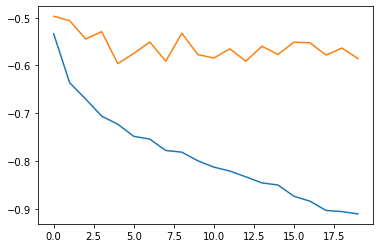

In [18]:
plt.plot(train_losses)
plt.plot(val_losses)